In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np

class DiffusionEncoder(Model):
    def __init__(self, latent_dim, timesteps=100):
        super(DiffusionEncoder, self).__init__()
        self.timesteps = timesteps
        self.latent_dim = latent_dim

        # 노이즈 스케줄링 (float32 변환 추가)
        self.beta = np.linspace(0.0001, 0.02, timesteps, dtype=np.float32)
        self.alpha = 1.0 - self.beta
        self.alpha_cumprod = tf.convert_to_tensor(np.cumprod(self.alpha, dtype=np.float32))

        # CNN 기반 Encoder (Skip Connection 포함)
        self.conv1 = layers.Conv1D(64, 7, strides=2, padding="same", activation="relu", input_shape=(192, 10))
        self.conv2 = layers.Conv1D(128, 5, strides=2, padding="same", activation="relu")
        self.conv3 = layers.Conv1D(256, 3, strides=2, padding="same", activation="relu")
        self.conv4 = layers.Conv1D(latent_dim, 3, strides=2, padding="same", activation="relu")  # Decoder 입력 크기에 맞춤

    def forward_diffusion(self, x):
        t = tf.random.uniform(shape=[], minval=1, maxval=self.timesteps, dtype=tf.int32)
        noise = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=1.0, dtype=tf.float32)
        alpha_cumprod_t = tf.gather(self.alpha_cumprod, t)
        alpha_cumprod_t = tf.cast(alpha_cumprod_t, tf.float32)
        x_t = tf.sqrt(alpha_cumprod_t) * x + tf.sqrt(1.0 - alpha_cumprod_t) * noise
        return x_t, t, noise

    def call(self, inputs):
        x_t, t, noise = self.forward_diffusion(inputs)
        skip1 = self.conv1(x_t)
        skip2 = self.conv2(skip1)
        skip3 = self.conv3(skip2)
        latent = self.conv4(skip3)
        return latent, [skip1, skip2, skip3], t, noise

class DiffusionDecoder(Model):
    def __init__(self, output_dim, latent_dim, timesteps=100):
        super(DiffusionDecoder, self).__init__()
        self.timesteps = timesteps
        self.latent_dim = latent_dim

        # Decoder 입력 차원 조정
        self.reshape_layer = layers.Conv1DTranspose(256, 3, strides=1, padding="same", activation="relu")

        # Skip Connection을 위한 1x1 Conv 적용
        self.skip1_conv = layers.Conv1D(64, 1, padding="same", activation="relu")
        self.skip2_conv = layers.Conv1D(128, 1, padding="same", activation="relu")
        self.skip3_conv = layers.Conv1D(256, 1, padding="same", activation="relu")

        # Decoder 레이어
        self.deconv1 = layers.Conv1DTranspose(256, 3, strides=2, padding="same", activation="relu")
        self.deconv2 = layers.Conv1DTranspose(128, 3, strides=2, padding="same", activation="relu")
        self.deconv3 = layers.Conv1DTranspose(64, 5, strides=2, padding="same", activation="relu")
        self.deconv4 = layers.Conv1DTranspose(output_dim, 7, strides=2, padding="same", activation="tanh")

    def reverse_diffusion(self, latent, noise, t, skip_features):
        x_t = self.reshape_layer(latent)

        # Skip Connection 시 채널 정렬을 위해 1x1 Conv 적용
        skip3 = self.skip3_conv(skip_features[2])
        x_t = tf.concat([x_t, skip3], axis=-1)

        x_t = self.deconv1(x_t)
        skip2 = self.skip2_conv(skip_features[1])
        x_t = tf.concat([x_t, skip2], axis=-1)

        x_t = self.deconv2(x_t)
        skip1 = self.skip1_conv(skip_features[0])
        x_t = tf.concat([x_t, skip1], axis=-1)

        x_t = self.deconv3(x_t)
        x_t = self.deconv4(x_t)

        return x_t

    def call(self, latent, noise, t, skip_features):
        return self.reverse_diffusion(latent, noise, t, skip_features)

class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = layers.Conv1D(64, 7, strides=2, padding="same", input_shape=(192, 10))
        self.conv2 = layers.Conv1D(128, 5, strides=2, padding="same")
        self.conv3 = layers.Conv1D(256, 3, strides=2, padding="same")
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(1, activation="sigmoid")
        self.activation = layers.LeakyReLU(negative_slope=0.2)

    def call(self, inputs):
        x = self.activation(self.conv1(inputs))
        x = self.activation(self.conv2(x))
        x = self.activation(self.conv3(x))
        x = self.flatten(x)
        return self.dense(x)

class DiffusionSkipGANomaly(Model):
    def __init__(self, input_dim, latent_dim):
        super(DiffusionSkipGANomaly, self).__init__()
        self.encoder = DiffusionEncoder(latent_dim)
        self.decoder = DiffusionDecoder(input_dim, latent_dim)
        self.discriminator = Discriminator()

    def call(self, inputs):
        latent, skip_features, t, noise = self.encoder(inputs)
        reconstructed = self.decoder(latent, noise, t, skip_features)
        disc_real = self.discriminator(inputs)
        disc_fake = self.discriminator(reconstructed)
        return reconstructed, disc_real, disc_fake, latent

if __name__ == "__main__":
    batch_size = 16
    input_data = tf.random.normal((batch_size, 192, 10))
    model = DiffusionSkipGANomaly(input_dim=10, latent_dim=128)
    reconstructed, disc_real, disc_fake, latent = model(input_data)

    print(f"Reconstructed shape: {reconstructed.shape}")
    print(f"Discriminator real output shape: {disc_real.shape}")
    print(f"Discriminator fake output shape: {disc_fake.shape}")
    print(f"Latent representation shape: {latent.shape}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:1387: UserWarning: Layer 'diffusion_decoder' looks like it has unbuilt state, but Keras is not able to trace the layer `call()` in order to build it automatically. Possible causes:
1. The `call()` method of your layer may be crashing. Try to `__call__()` the layer eagerly on some test input first to see if it works. E.g. `x = np.random.random((3, 4)); y = layer(x)`
2. If the `call()` method is correct, then you may need to implement the `def build(self, input_shape)` method on your layer. It should create all variables used by the layer (e.g. by calling `layer.build()` on all its ch

InvalidArgumentError: Exception encountered when calling DiffusionDecoder.call().

[1m{{function_node __wrapped__ConcatV2_N_2_device_/job:localhost/replica:0/task:0/device:GPU:0}} ConcatOp : Dimension 1 in both shapes must be equal: shape[0] = [16,12,256] vs. shape[1] = [16,24,256] [Op:ConcatV2] name: concat[0m

Arguments received by DiffusionDecoder.call():
  • latent=tf.Tensor(shape=(16, 12, 128), dtype=float32)
  • noise=tf.Tensor(shape=(16, 192, 10), dtype=float32)
  • t=tf.Tensor(shape=(), dtype=int32)
  • skip_features=['tf.Tensor(shape=(16, 96, 64), dtype=float32)', 'tf.Tensor(shape=(16, 48, 128), dtype=float32)', 'tf.Tensor(shape=(16, 24, 256), dtype=float32)']

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 데이터 로드
file_path = "/content/drive/MyDrive/Colab Notebooks/combined_dataset.xlsx"
df = pd.read_excel(file_path)  # read_csv -> read_excel로 변경
df

,Num.,subject_ID,Sex(M/F),Age(year),Height(cm),Weight(kg),Systolic Blood Pressure(mmHg),Diastolic Blood Pressure(mmHg),Heart Rate(b/m),BMI(kg/m^2),...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,1,2,Female,45,152,63,161,89,97,27.268006,...,1766,1766,1766,1833,1833,1827,1827,1827,1754,1754
1,1,2,Female,45,152,63,161,89,97,27.268006,...,1985,1985,2026,2026,2026,1977,1977,1997,1997,1997
2,1,2,Female,45,152,63,161,89,97,27.268006,...,1942,1900,1900,1938,1938,1938,1924,1924,1929,1929
3,2,3,Female,50,157,50,160,93,76,20.284799,...,2073,2072,2072,2072,2051,2051,2036,2036,2036,2045
4,2,3,Female,50,157,50,160,93,76,20.284799,...,2021,2010,2010,2010,2001,2001,2003,2003,2003,1989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
652,218,418,Male,25,173,63,106,69,67,21.049818,...,2702,2671,2679,2675,2695,2703,2667,2662,2687,2635
653,218,418,Male,25,173,63,106,69,67,21.049818,...,2391,2362,2378,2363,2323,2355,2355,2395,2362,2367
654,219,419,Male,24,175,58,108,68,65,18.938776,...,2399,2463,2415,2406,2407,2447,2435,2422,2451,2379
655,219,419,Male,24,175,58,108,68,65,18.938776,...,3075,3091,3067,3051,3121,3135,3091,3103,3146,3151


In [ ]:
df['Hypertension'].value_counts()

,count
Hypertension,
Prehypertension,255
Normal,240
Stage 1 hypertension,102
Stage 2 hypertension,60


In [ ]:
# Normal을 8:2로 나눔 (훈련: 80%, 테스트: 20%)
normal_train, normal_test = train_test_split(
    df[df["Hypertension"] == "Normal"], test_size=0.2, random_state=42
)

# 나머지 클래스는 테스트 데이터에만 포함
test_data = normal_test.copy()
for category in ["Prehypertension", "Stage 1 hypertension", "Stage 2 hypertension"]:
    _, test = train_test_split(
        df[df["Hypertension"] == category], test_size=0.2, random_state=42
    )
    test_data = pd.concat([test_data, test])

# 훈련 데이터는 Normal만 포함
train_data = normal_train.copy()

In [ ]:
train_data["Hypertension"].value_counts()

,count
Hypertension,
Normal,192


In [ ]:
test_data["Hypertension"].value_counts()

,count
Hypertension,
Prehypertension,51
Normal,48
Stage 1 hypertension,21
Stage 2 hypertension,12


In [ ]:
train_data

,Num.,subject_ID,Sex(M/F),Age(year),Height(cm),Weight(kg),Systolic Blood Pressure(mmHg),Diastolic Blood Pressure(mmHg),Heart Rate(b/m),BMI(kg/m^2),...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
382,128,172,Female,32,151,61,101,70,79,26.753213,...,2130,2141,2141,2124,2124,2124,2120,2120,2159,2159
141,48,63,Female,55,156,55,101,63,62,22.600263,...,1743,1743,1722,1722,1722,1729,1729,1754,1754,1754
618,207,406,Female,26,171,75,106,63,69,25.648918,...,2910,2943,2890,2879,2894,2882,2883,2875,2867,2895
579,194,247,Male,64,154,51,98,59,80,21.504470,...,1840,1878,1878,1878,1817,1817,1819,1819,1819,1849
621,208,407,Female,24,155,38,96,67,82,15.816857,...,2779,2763,2783,2759,2771,2824,2770,2835,2854,2755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,93,131,Male,67,159,43,116,61,80,17.008821,...,2615,2615,2522,2522,2548,2548,2548,2526,2526,2607
38,13,17,Female,48,155,57,117,70,75,23.725286,...,2266,2266,2214,2214,2219,2219,2219,2286,2286,2226
245,82,116,Male,64,165,55,80,48,53,20.202020,...,1957,1971,1971,1984,1984,1984,1946,1946,1966,1966
536,179,230,Female,80,152,59,119,61,76,25.536704,...,2149,2149,2084,2084,2104,2104,2104,2092,2092,2102


In [ ]:

ppg_columns = [str(i) for i in range(2091, 2101)]

# 'Hypertension'이 0 (Normal)인 데이터만 훈련 데이터로 선택
train_data = train_data[train_data["Hypertension"] == 'Normal'][ppg_columns]

# 테스트 데이터는 기존과 동일하게 유지 (Hypertension 레이블 + PPG 데이터)
test_data = test_data[["Hypertension"] + ppg_columns]



In [ ]:
train_data

,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
382,2130,2141,2141,2124,2124,2124,2120,2120,2159,2159
141,1743,1743,1722,1722,1722,1729,1729,1754,1754,1754
618,2910,2943,2890,2879,2894,2882,2883,2875,2867,2895
579,1840,1878,1878,1878,1817,1817,1819,1819,1819,1849
621,2779,2763,2783,2759,2771,2824,2770,2835,2854,2755
...,...,...,...,...,...,...,...,...,...,...
277,2615,2615,2522,2522,2548,2548,2548,2526,2526,2607
38,2266,2266,2214,2214,2219,2219,2219,2286,2286,2226
245,1957,1971,1971,1984,1984,1984,1946,1946,1966,1966
536,2149,2149,2084,2084,2104,2104,2104,2092,2092,2102


In [ ]:
test_data

,Hypertension,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
54,Normal,2074,2074,2080,2080,2079,2079,2079,2099,2099,2076
24,Normal,1858,1864,1864,1864,1866,1866,1879,1879,1879,1864
246,Normal,2309,2330,2330,2305,2305,2305,2364,2364,2367,2367
310,Normal,2526,2532,2532,2532,2557,2557,2532,2532,2532,2543
269,Normal,2000,2000,2000,1997,1997,1985,1985,1985,2008,2008
...,...,...,...,...,...,...,...,...,...,...,...
336,Stage 2 hypertension,2421,2469,2469,2469,2487,2487,2439,2439,2439,2506
69,Stage 2 hypertension,2324,2327,2327,2335,2335,2335,2421,2421,2358,2358
528,Stage 2 hypertension,1899,1897,1897,1883,1883,1883,1882,1882,1921,1921
283,Stage 2 hypertension,2194,2194,2194,2173,2173,2185,2185,2185,2168,2168


In [ ]:
test_data['Hypertension'].value_counts()

,count
Hypertension,
Prehypertension,51
Normal,48
Stage 1 hypertension,21
Stage 2 hypertension,12


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Label Encoding을 위한 변환기 생성
label_encoder = LabelEncoder()

# Hypertension 컬럼을 Label Encoding 적용
test_data["Hypertension_Encoded"] = label_encoder.fit_transform(test_data["Hypertension"])

# 기존 Hypertension 컬럼 제거 후 새로운 컬럼으로 대체
test_data_encoded = test_data.drop(columns=["Hypertension"]).rename(columns={"Hypertension_Encoded": "Hypertension"})



In [ ]:
test_data_encoded

,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100,Hypertension
54,2074,2074,2080,2080,2079,2079,2079,2099,2099,2076,0
24,1858,1864,1864,1864,1866,1866,1879,1879,1879,1864,0
246,2309,2330,2330,2305,2305,2305,2364,2364,2367,2367,0
310,2526,2532,2532,2532,2557,2557,2532,2532,2532,2543,0
269,2000,2000,2000,1997,1997,1985,1985,1985,2008,2008,0
...,...,...,...,...,...,...,...,...,...,...,...
336,2421,2469,2469,2469,2487,2487,2439,2439,2439,2506,3
69,2324,2327,2327,2335,2335,2335,2421,2421,2358,2358,3
528,1899,1897,1897,1883,1883,1883,1882,1882,1921,1921,3
283,2194,2194,2194,2173,2173,2185,2185,2185,2168,2168,3


In [ ]:
test_data_encoded['Hypertension'].value_counts()

,count
Hypertension,
1,51
0,48
2,21
3,12


In [ ]:
train_data.shape

(192, 10)

In [ ]:
BATCH = 32  # 원하는 배치 크기

# (192, 10) -> (BATCH, 192, 10) 변환
train_data_batch = np.expand_dims(train_data, axis=0).repeat(BATCH, axis=0)

In [ ]:
train_data_batch.shape

(32, 192, 10)

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.optimizers import Adam

# 모델 초기화
input_dim = 10  # 입력 차원 (특성 수)
latent_dim = 64  # 잠재 공간 차원
model = DiffusionSkipGANomaly(input_dim, latent_dim)

# 옵티마이저 설정
generator_optimizer = Adam(learning_rate=1e-4)
discriminator_optimizer = Adam(learning_rate=1e-4)

# 손실 함수
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def generator_loss(fake_output):
    """ Generator 손실: 생성된 데이터가 진짜로 분류되도록 유도 """
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    """ Discriminator 손실: 진짜와 가짜를 구별하도록 유도 """
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

# 학습 스텝
@tf.function
def train_step(input_data):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # 모델 순전파
        reconstructed, disc_real, disc_fake, _ = model(input_data)

        # 손실 계산
        gen_loss = generator_loss(disc_fake)
        disc_loss = discriminator_loss(disc_real, disc_fake)

    # 그래디언트 계산 및 업데이트
    generator_gradients = gen_tape.gradient(gen_loss, model.encoder.trainable_variables + model.decoder.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, model.discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, model.encoder.trainable_variables + model.decoder.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, model.discriminator.trainable_variables))

    return gen_loss, disc_loss



In [ ]:
# 하이퍼파라미터 설정
batch_size = 32
epochs = 50
input_dim = 10  # 입력 차원 (특성 수)
latent_dim = 64  # 잠재 공간 차원

In [ ]:
# 학습 루프
def train(dataset, epochs):
    for epoch in range(epochs):
        gen_loss_avg = tf.keras.metrics.Mean()
        disc_loss_avg = tf.keras.metrics.Mean()

        for batch in dataset:
            gen_loss, disc_loss = train_step(batch)
            gen_loss_avg.update_state(gen_loss)
            disc_loss_avg.update_state(disc_loss)

        print(f"Epoch {epoch+1}, Generator Loss: {gen_loss_avg.result().numpy()}, Discriminator Loss: {disc_loss_avg.result().numpy()}")


In [ ]:
# 모델 학습
train(dataset, epochs=50)

ValueError: in user code:

    File "<ipython-input-115-1fb23f57a8ff>", line 24, in train_step  *
        reconstructed, disc_real, disc_fake, _ = model(input_data)
    File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "<ipython-input-61-beda9ceb0545>", line 117, in call
        latent, skip_features, t, noise = self.encoder(inputs)  # Skip Features 포함
    File "<ipython-input-61-beda9ceb0545>", line 44, in call
        skip1 = self.conv1(x_t)

    ValueError: Exception encountered when calling DiffusionEncoder.call().
    
    [1mInput 0 of layer "conv1d_149" is incompatible with the layer: expected min_ndim=3, found ndim=2. Full shape received: (32, 10)[0m
    
    Arguments received by DiffusionEncoder.call():
      • inputs=tf.Tensor(shape=(32, 10), dtype=float32)


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


# (192, 30, 10)으로 변환
sequence_length = 30
input_dim = 10

batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(train_data).shuffle(buffer_size=1024).batch(batch_size)



AttributeError: '_BatchDataset' object has no attribute 'shape'

In [ ]:
threshold =  0.1

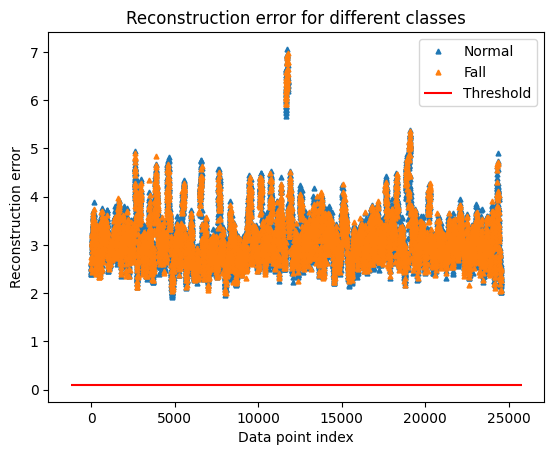

In [ ]:
groups = reconstruction_df.groupby('type')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='^', ms=3.5, linestyle='',
            label= "Normal" if name == 0 else "Fall")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();